## Imports and Hyperparameters

In [78]:
import os
import glob
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Activation, CenterCrop
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from classifiers.WDI_1NN import WDI_1NN
from classifiers.ACM_SVM import ACM_SVM
from classifiers.CASIM import CASIM
from classifiers.EAC_1NN import EAC_KNN
from classifiers.MBW_LR import MBW_LR

In [79]:
RANDOM_SEED = 42
N_REPEATS = 20
N_SPLITS = 5
MAX_DATA_LENGTH = 60
PERTURBATION_STEP_SIZE = 0.025
PERTURBATION_STEPS = 8
NUM_EPOCHS = 50

SAVE_DIR_TEP = "results"
SAVE_DIR_FCC = "results"

wdi_1nn_params = {"template_threshold": 0.5, "n_neighbors": 1}
acm_svm_params = {None}
casim_params={
        "num_features": 672,
        "n_estimators": 1,
        "n_jobs_multirocket": 1,
        "random_state": RANDOM_SEED,
        "alphas": np.logspace(-3, 3, 10),
    }
eac_1nn_params = {"attenuation_coefficient_per_min": 0.0667, "n_neighbors": 1}
mbw_lr_params = {
        "penalty": None,
        "fit_intercept": False,
        "solver": "lbfgs",
        "multi_class": "ovr",
        "decision_bounds": True,
        "confidence_interval": 1.96,
    }

CLASSIFIERS = {
    "WDI_1NN": (WDI_1NN, wdi_1nn_params),
    "CASIM": (CASIM, casim_params),
    "EAC_1NN": (EAC_KNN, eac_1nn_params),
    "MBW_LR": (MBW_LR, mbw_lr_params),
    "ACM_SVM": (ACM_SVM, acm_svm_params),
}

CLASSIFIERS_EAC_KNN = {}
for i in [1, 5, 10, 25, 50]:
    params = {"attenuation_coefficient_per_min": 0.0667, "n_neighbors": i}
    CLASSIFIERS_EAC_KNN[f"EAC_{i}NN"] = (EAC_KNN, params)

## Load Data and Original Labels

In [87]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def load_dataset_from_folder(base_path, max_data_length):
    """
    Load time-series CSV files organized in subfolders per class.

    Parameters
    ----------
    base_path : str or Path
        Path to the folder containing one subfolder per class.
        Each class subfolder should contain CSV files (all same shape).
    max_data_length : int
        Maximum length of the time series data (number of timesteps).

    Returns
    -------
    X : np.ndarray
        Array of shape (n_samples, n_variables, n_timesteps)
    y : np.ndarray
        Array of integer labels (0..n_classes-1)

    Also prints:
    - mapping from numeric labels to folder names
    - shapes of X and y
    """
    data = []
    labels = []

    # Find subfolders (classes) in deterministic order
    class_folders = sorted(
        [
            d for d in os.listdir(base_path)
            if os.path.isdir(os.path.join(base_path, d))
        ]
    )
    if not class_folders:
        raise ValueError(f"No class subfolders found in {base_path}")

    # Print mapping from label index to folder name
    print("Class mapping (label_index -> folder_name):")
    for idx, cname in enumerate(class_folders):
        print(f"  {idx}: {cname}")

    # Build list of files to load (with labels) to show a single progress bar
    files_to_load = []
    for label, class_name in enumerate(class_folders):
        class_dir = os.path.join(base_path, class_name)
        # Collect CSV files in deterministic order
        csv_files = sorted(
            [
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(".csv")
            ]
        )
        if not csv_files:
            raise ValueError(f"No CSV files found in class folder {class_dir}")

        for fname in csv_files:
            files_to_load.append((os.path.join(class_dir, fname), label))

    # Iterate with tqdm progress bar
    for csv_path, label in tqdm(files_to_load, desc="Loading dataset", unit="file"):
        df = pd.read_csv(csv_path, index_col=0)
        arr = df.values.T  # (variables, timesteps)
        data.append(arr)
        labels.append(label)

    # Ensure all samples have the same shape
    shapes = {a.shape for a in data}
    if len(shapes) != 1:
        raise ValueError(f"Inconsistent sample shapes found: {shapes}")

    X = np.array(data)
    y = np.array(labels)

    # Resize data to max_data_length if necessary
    if X.shape[2] > max_data_length:
        X = X[:, :, :max_data_length]

    print("Data shape:", X.shape)
    print("Labels shape:", y.shape)

    return X, y

## Label Perturbation

In [81]:
class CAELabelPerturber:
    """
    Class to handle label perturbation operations based on autoencoder latent distances.

    The autoencoder is a convolutional encoder-decoder:
    - Input: (features, time)
    - Internally reshaped to (features, time, 1)
    - Encoder: Conv2D stack -> latent feature map
    - Encoder model outputs flattened latent vector (for Euclidean distances)
    """

    def __init__(self,
                 random_state: Optional[int] = None,
                 latent_dim: int = 32,
                 epochs: int = 10):
        """
        Parameters
        ----------
        random_state : int or None
            Random seed for reproducibility.
        latent_dim : int
            Number of filters in the final encoder Conv2D layer (depth of latent_map).
        epochs : int
            Number of epochs for autoencoder training.
        """
        self.random_state = random_state
        self.latent_dim = latent_dim
        self.epochs = epochs

        self.perturbation_map: Optional[List[Dict[str, Any]]] = None
        self.X = None
        self.y = None

        self.autoencoder: Optional[Model] = None
        self.encoder: Optional[Model] = None

        # Scaler for normalizing distances to [0, 1]
        self.scaler = MinMaxScaler()

    def _build_autoencoder(self, input_shape):
        """
        Build CNN autoencoder model for binary time series data.

        Parameters
        ----------
        input_shape : tuple
            Shape of a single sample (features, time).
        """
        height, width = input_shape  # (features, time)

        # Add channel dimension for Conv2D: (features, time, 1)
        inp = Input(shape=(height, width, 1), name="encoder_input")

        # Encoder (all CNN)
        x = Conv2D(32, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_32")(inp)
        x = Conv2D(64, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_64")(x)
        x = Conv2D(128, 3, strides=2, padding="same",
                   activation="relu", name="enc_conv_128")(x)
        latent_map = Conv2D(self.latent_dim, 3, strides=2, padding="same",
                            activation="relu", name="latent_map")(x)

        # Decoder (mirror of encoder)
        y = Conv2DTranspose(128, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_128")(latent_map)
        y = Conv2DTranspose(64, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_64")(y)
        y = Conv2DTranspose(32, 3, strides=2, padding="same",
                            activation="relu", name="dec_deconv_32")(y)
        y = Conv2DTranspose(1, 3, strides=2, padding="same",
                            name="dec_deconv_1")(y)

        # Sigmoid -> probabilities of "alarm active"
        y = Activation("sigmoid", name="recon_prob")(y)

        # Ensure exact spatial size (features, time)
        y = CenterCrop(height, width, name="center_crop")(y)

        # Autoencoder model: from input to reconstructed probabilities
        self.autoencoder = Model(inp, y, name="autoencoder")

        # Encoder model: from input to flattened latent vector
        latent_flat = Flatten(name="latent_flat")(latent_map)
        self.encoder = Model(inp, latent_flat, name="encoder")

        # Loss and metric (binary reconstruction)
        bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        bin_acc = tf.keras.metrics.BinaryAccuracy(
            threshold=0.5, name="bin_acc"
        )

        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=bce_loss,
            metrics=[bin_acc],
        )

    def _latent_distance(self, latent1: np.ndarray, latent2: np.ndarray) -> float:
        """
        Calculate Euclidean distance between latent representations.

        Parameters
        ----------
        latent1, latent2 : np.ndarray
            Latent-space vectors.

        Returns
        -------
        float
            Euclidean distance.
        """
        euclidean_dist = np.linalg.norm(latent1 - latent2)
        return euclidean_dist

    def fit_labels(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the perturber by training the autoencoder and creating the perturbation map.

        Parameters
        ----------
        X : np.ndarray
            Input data of shape (n_samples, features, time). Values are expected to be binary (0/1)
            or at least bounded in [0, 1].
        y : np.ndarray
            Array of class labels (one per sample).
        """
        self.X = X
        self.y = y
        n_samples = len(X)

        # Build autoencoder for this input shape
        input_shape = X.shape[1:]  # (features, time)
        self._build_autoencoder(input_shape)

        # Normalize input data to [0, 1] if possible
        X_float = X.astype("float32")
        max_val = np.max(X_float)
        if max_val > 0.0:
            X_normalized = X_float / max_val
        else:
            X_normalized = X_float

        # Add channel dimension: (n_samples, features, time, 1)
        X_ae = X_normalized[..., np.newaxis]

        # Train autoencoder
        print(f"Training autoencoder for {self.epochs} epochs...")
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            np.random.seed(self.random_state)

        history = self.autoencoder.fit(
            X_ae, X_ae,
            epochs=self.epochs,
            batch_size=32,
            verbose=1,
            validation_split=0.1,
        )
        print("Autoencoder training completed.")

        # Get latent representations (flattened)
        latent_representations = self.encoder.predict(X_ae, verbose=0)

        # Normalize distances using all pairwise distances
        all_distances = []
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                dist = self._latent_distance(
                    latent_representations[i], latent_representations[j]
                )
                all_distances.append(dist)

        all_distances = np.array(all_distances).reshape(-1, 1)
        self.scaler.fit(all_distances)

        # Build perturbation map: for each sample, find closest sample from a different class
        self.perturbation_map = []

        for i in tqdm(range(n_samples), desc="Building perturbation map"):
            current_latent = latent_representations[i]
            current_label = y[i]

            min_distance = float("inf")
            closest_different_label = None

            for j in range(n_samples):
                if i == j:
                    continue
                if y[j] == current_label:
                    continue

                distance = self._latent_distance(
                    current_latent, latent_representations[j]
                )
                distance_normalized = self.scaler.transform([[distance]])[0][0]

                if distance_normalized < min_distance:
                    min_distance = distance_normalized
                    closest_different_label = y[j]

            self.perturbation_map.append(
                {
                    "original_label": current_label,
                    "new_label": closest_different_label,
                    "distance": min_distance,
                }
            )
        print("Built perturbation map.")

    def perturb_labels(self,
                       y: np.ndarray,
                       perturbation_level: int,
                       perturbation_step_size: float = 0.1) -> np.ndarray:
        """
        Perturb labels based on the perturbation map and a given perturbation level.

        Parameters
        ----------
        y : np.ndarray
            Array of labels (should match the y used in fit_labels).
        perturbation_level : int
            Integer step level (0 = no perturbation).
        perturbation_step_size : float
            Fraction of samples to perturb per step (e.g., 0.1 = 10% per level).

        Returns
        -------
        np.ndarray
            Perturbed labels.
        """
        if perturbation_level == 0 or self.perturbation_map is None:
            return y.copy()

        if self.random_state is not None:
            np.random.seed(self.random_state)

        y_perturbed = y.copy()
        num_samples = len(y)
        
        # Get unique classes
        unique_classes = np.unique(y)
        
        # For each class, find the top X% with smallest distances
        perturb_indices = []
        
        for class_label in unique_classes:
            # Find indices of samples belonging to this class
            class_indices = np.where(y == class_label)[0]
            
            # Get perturbation info for this class
            class_perturbation_info = [(idx, self.perturbation_map[idx]["distance"]) 
                                     for idx in class_indices 
                                     if self.perturbation_map[idx]["new_label"] is not None]
            
            if not class_perturbation_info:
                continue
                
            # Sort by distance (ascending) for this class
            class_perturbation_info.sort(key=lambda x: x[1])
            
            # Calculate number to perturb for this class
            num_class_samples = len(class_indices)
            num_perturb_class = int(num_class_samples * perturbation_step_size * perturbation_level)
            
            if num_perturb_class == 0:
                continue
                
            # Select the samples with lowest distances for this class
            class_perturb_indices = [idx for idx, _ in class_perturbation_info[:num_perturb_class]]
            perturb_indices.extend(class_perturb_indices)

        # Apply perturbations
        for idx in perturb_indices:
            new_label = self.perturbation_map[idx]["new_label"]
            if new_label is not None:
                y_perturbed[idx] = new_label

        return y_perturbed

## Robustness Tester

In [82]:
class RobustnessTester:
    """Class to test model robustness against label perturbations"""
    
    def __init__(self, classifiers_dict, perturber, n_splits=5, n_repeats=1, perturbation_step_size=0.1, 
                 random_state=None):
        """
        Parameters:
        - classifiers_dict: dictionary with classifier info {name: (class, params)}
        - perturber: LabelPerturber instance
        - n_splits: number of CV folds
        - n_repeats: number of CV repeats
        - perturbation_step_size: percentage per perturbation step
        - random_state: random seed for reproducibility
        """
        self.classifiers_dict = classifiers_dict
        self.perturber = perturber
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.perturbation_step_size = perturbation_step_size
        self.random_state = random_state
    
    def _process_confusion_matrices(self, confusion_matrices, classifier_name, y):
        """Helper function to process confusion matrices into DataFrame"""
        cm_list = []
        for step, cm in confusion_matrices.items():
            cm_flat = cm.flatten()
            cm_dict = {
                f'cm_{i}_{j}': cm_flat[i * len(np.unique(y)) + j]
                for i in range(len(np.unique(y)))
                for j in range(len(np.unique(y)))
            }
            cm_dict['classifier'] = classifier_name
            cm_dict['perturbation_percentage'] = round(self.perturbation_step_size * step * 100)
            cm_list.append(cm_dict)
        
        return pd.DataFrame(cm_list).set_index('perturbation_percentage')
    
    def _process_perturbation_maps(self, perturbation_maps_per_fold, y_train_folds):
        """Helper function to process perturbation maps into DataFrame"""
        pm_list = []
        unique_labels = np.unique(np.concatenate(y_train_folds))
        
        for fold, fold_maps in enumerate(perturbation_maps_per_fold):
            # Initialize confusion matrix structure for this fold
            cm_shape = (len(unique_labels), len(unique_labels))
            fold_cm = np.zeros(cm_shape, dtype=float)  # use float for safe division later
            
            # Aggregate all perturbations for this fold
            for perturbation in fold_maps:
                original_label = perturbation['original_label']
                target_label = perturbation['new_label']
                
                # Skip entries without a valid target label (just to be safe)
                if target_label is None:
                    continue
                
                # Convert labels to indices for confusion matrix
                orig_idx = np.where(unique_labels == original_label)[0][0]
                target_idx = np.where(unique_labels == target_label)[0][0]
                fold_cm[orig_idx, target_idx] += 1
            
            # --- NEW: normalize out repeated counting of the same map per fold ---
            n_train = len(y_train_folds[fold])
            total = fold_cm.sum()
            if n_train > 0 and total > n_train:
                # Average number of times each sample was counted
                factor = total / n_train
                # Round to nearest integer factor (should be very close to an integer)
                factor_int = max(1, int(round(factor)))
                if factor_int > 1:
                    fold_cm = fold_cm / factor_int
            
            # Convert back to integer counts
            fold_cm = fold_cm.astype(int)
            
            # Convert to dictionary format
            cm_flat = fold_cm.flatten()
            cm_dict = {
                f'cm_{i}_{j}': cm_flat[i * len(unique_labels) + j]
                for i in range(len(unique_labels))
                for j in range(len(unique_labels))
            }
            cm_dict['fold'] = fold
            pm_list.append(cm_dict)
        
        return pd.DataFrame(pm_list).set_index('fold')

        
    def test_robustness(self, X, y, perturbation_steps=10):
        """
        Test robustness of all classifiers against label perturbation.
        
        Parameters:
        - X: feature data
        - y: labels
        - perturbation_steps: maximum perturbation level to test
        
        Returns:
        - results dict with DataFrames for each classifier
        - confusion_matrices dict with DataFrames for each classifier
        - perturbation_maps DataFrame (shared across all classifiers)
        """
        np.random.seed(self.random_state)
        skf = RepeatedStratifiedKFold(
            n_splits=self.n_splits,
            n_repeats=self.n_repeats,
            random_state=self.random_state
        )
        
        # Initialize storage for all classifiers
        all_results = {name: [] for name in self.classifiers_dict.keys()}
        all_confusion_matrices = {
            name: {step: None for step in range(0, perturbation_steps + 1)}
            for name in self.classifiers_dict.keys()
        }
        perturbation_maps_per_fold = []
        y_train_folds = []
        
        # Main loop: folds first
        for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(f"Processing Fold {fold}...")
            
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_train_folds.append(y_train)
            
            # Fit perturber on training data (once per fold)
            self.perturber.fit_labels(X_train, y_train)
            
            # Prepare parallel computation for perturbation steps
            steps = list(range(0, perturbation_steps + 1))
            
            def _process_step(step):
                """
                Worker function for a single perturbation step.
                Returns:
                - step index
                - list of result dicts (one per classifier)
                - dict of confusion matrices {classifier_name: cm}
                - perturbation map for this step (copy of self.perturber.perturbation_map)
                """
                # Perturb training labels using fitted perturber
                y_train_perturbed = self.perturber.perturb_labels(
                    y_train, step, self.perturbation_step_size
                )
                perturbation_percentage = round(self.perturbation_step_size * step * 100)
                
                step_results = []
                step_cms = {}
                
                # Loop over classifiers
                for classifier_name, (classifier_class, classifier_params) in self.classifiers_dict.items():
                    # Train model on perturbed data
                    model_instance = classifier_class(classifier_params)
                    model_instance.fit(X_train, y_train_perturbed)
                    
                    # Evaluate on unperturbed test data
                    y_pred = model_instance.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    step_results.append({
                        'classifier_name': classifier_name,
                        'fold': fold,
                        'perturbation_percentage': perturbation_percentage,
                        'accuracy': accuracy
                    })
                    
                    # Confusion matrix for this classifier and step (for this fold only)
                    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
                    step_cms[classifier_name] = cm
                
                # Copy perturbation map (same for all steps, but we preserve original behavior)
                step_pm = self.perturber.perturbation_map.copy()
                
                return step, step_results, step_cms, step_pm
            
            # Parallel execution over perturbation steps
            # n_jobs=-1 uses all available cores; adjust as needed
            parallel_outputs = Parallel(n_jobs=-1)(
                delayed(_process_step)(step)
                for step in tqdm(steps, desc="Perturbation steps")
            )
            
            # Aggregate results from all steps for this fold
            fold_perturbation_maps = []
            
            for step, step_results, step_cms, step_pm in parallel_outputs:
                # Append per-classifier results
                for res in step_results:
                    classifier_name = res['classifier_name']
                    # Store without classifier_name (keyed by dict)
                    all_results[classifier_name].append({
                        'fold': res['fold'],
                        'perturbation_percentage': res['perturbation_percentage'],
                        'accuracy': res['accuracy']
                    })
                
                # Accumulate confusion matrices over folds
                for classifier_name, cm in step_cms.items():
                    if all_confusion_matrices[classifier_name][step] is None:
                        all_confusion_matrices[classifier_name][step] = cm
                    else:
                        all_confusion_matrices[classifier_name][step] += cm
                
                # Preserve original behavior: extend maps for each step
                fold_perturbation_maps.extend(step_pm)
            
            # Store perturbation maps for this fold
            perturbation_maps_per_fold.append(fold_perturbation_maps)
        
        # Process results for each classifier
        processed_results = {}
        processed_confusion_matrices = {}
        
        for classifier_name in self.classifiers_dict.keys():
            # Process accuracy results
            results_df = pd.DataFrame(all_results[classifier_name])
            results_pivot = results_df.pivot_table(
                index='perturbation_percentage', 
                columns='fold', 
                values='accuracy'
            )
            results_pivot['average'] = results_pivot.mean(axis=1)
            processed_results[classifier_name] = results_pivot
            
            # Process confusion matrices
            processed_confusion_matrices[classifier_name] = self._process_confusion_matrices(
                all_confusion_matrices[classifier_name], classifier_name, y
            )
        
        # Process perturbation maps (shared across all classifiers)
        perturbation_maps_df = self._process_perturbation_maps(
            perturbation_maps_per_fold, y_train_folds
        )
        
        return processed_results, processed_confusion_matrices, perturbation_maps_df
    
    def test_all_classifiers(self, X, y, perturbation_steps=10, results_folder=None):
        """
        Test robustness of all classifiers in the dictionary.
        
        Parameters:
        - X: feature data
        - y: labels  
        - perturbation_steps: maximum perturbation level to test
        - results_folder: folder to save results CSV files

        Returns:
        - Dictionary with results for each classifier
        """
        print(f"\nTesting robustness of all classifiers...")
        
        results, cm, pm = self.test_robustness(X, y, perturbation_steps)
        
        all_results = {}
        for classifier_name in self.classifiers_dict.keys():
            all_results[classifier_name] = {
                'results': results[classifier_name], 
                'confusion_matrices': cm[classifier_name],
                'perturbation_maps': pm  # Shared across all classifiers
            }
            
            if results_folder is not None:
                os.makedirs(results_folder, exist_ok=True)
                results[classifier_name].to_csv(
                    f"{results_folder}/{classifier_name}_robustness_results.csv"
                )
                cm[classifier_name].to_csv(
                    f"{results_folder}/{classifier_name}_confusion_matrices.csv"
                )
        
        # Save perturbation maps only once (shared across all classifiers)
        if results_folder is not None:
            pm.to_csv(f"{results_folder}/perturbation_maps.csv")
        
        return all_results

## Visualization

In [83]:
def plot_robustness_results(classifiers_dict, results_folder, save_filename=None):
    """
    Load robustness results and create a visualization plot.
    
    Parameters:
    - classifiers_dict: dictionary of classifiers used in the experiment
    - results_folder: path to folder containing the results CSV files
    - save_filename: optional filename to save the plot (with .svg extension)
    """
    # Load all robustness results CSV files
    files = glob.glob(f'{results_folder}/*_robustness_results.csv')
    
    if not files:
        print(f"No robustness results files found in {results_folder}")
        return
    
    # Initialize a dictionary to store data
    data = {}
    x_labels = None
    
    # Read each file and store the average column
    for file in files:
        # Extract classifier name from filename
        filename = os.path.basename(file)
        classifier_name = filename.replace('_robustness_results.csv', '')
        
        if classifier_name in classifiers_dict:
            df = pd.read_csv(file, index_col=0)
            data[classifier_name] = df['average']
            if x_labels is None:
                x_labels = df.index  # perturbation_percentage values
    
    if not data:
        print("No valid classifier data found")
        return
    
    # Create a DataFrame from the dictionary
    results_df = pd.DataFrame(data)
    
    # Define diverse styles for each classifier
    colors = ['#00B0F0', '#12B65C', '#FFC000', '#FF0400', '#A52A2A', '#800080', '#FFA500', '#008000']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', 'D', 'X', '*', 'P']
    
    markersize = 8
    linewidth = 2.5
    
    # Create style dictionary for each classifier
    styles = {}
    for i, classifier in enumerate(data.keys()):
        styles[classifier] = {
            'color': colors[i % len(colors)],
            'linestyle': linestyles[i % len(linestyles)],
            'marker': markers[i % len(markers)],
            'markersize': markersize,
            'linewidth': linewidth
        }
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for classifier, style in styles.items():
        ax.plot(x_labels, results_df[classifier], label=classifier, **style)
    
    plt.title('Classifier Robustness to Label Perturbation')
    plt.xlabel('Perturbation Percentage (%)')
    plt.ylabel('Average Accuracy')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Classifier')
    
    # Save the plot if filename provided
    if save_filename:
        plt.savefig(f'{results_folder}/{save_filename}')
    
    plt.show()

In [84]:
def plot_robustness_results_subfigure(classifiers_dict,
                                      results_folder,
                                      save_filename=None,
                                      fine_results_folder=None,
                                      inset_xlim=(0, 20),
                                      inset_width="34%",
                                      inset_height="34%",
                                      inset_bbox=(0.10, 0.10, 1, 1)):
    """
    Load robustness results and create a visualization plot with an optional
    zoomed-in inset for low perturbation levels.

    Parameters:
    - classifiers_dict: dict of classifiers used in the experiment
    - results_folder: path to folder containing the coarse results CSV files
    - save_filename: optional filename to save the plot (e.g., 'robustness.svg')
    - fine_results_folder: optional path to folder containing fine-grained
      results (e.g., 1% steps for 0–20%); if None, inset reuses coarse data.
    - inset_xlim: tuple (xmin, xmax) for the zoom region in percent
    - inset_width, inset_height: size of inset for inset_axes (e.g., "34%")
    - inset_bbox: (x0, y0, width, height) for bbox_to_anchor of inset
    """
    # ----------------------------------------------------------------------
    # Load coarse robustness results
    # ----------------------------------------------------------------------
    files = glob.glob(os.path.join(results_folder, '*_robustness_results.csv'))

    if not files:
        print(f"No robustness results files found in {results_folder}")
        return

    coarse_data = {}
    x_labels = None

    for file in files:
        filename = os.path.basename(file)
        classifier_name = filename.replace('_robustness_results.csv', '')

        if classifier_name in classifiers_dict:
            df = pd.read_csv(file, index_col=0)
            coarse_data[classifier_name] = df['average']
            if x_labels is None:
                x_labels = df.index  # perturbation_percentage values

    if not coarse_data:
        print("No valid classifier data found")
        return

    coarse_df = pd.DataFrame(coarse_data)

    # ----------------------------------------------------------------------
    # Optionally load fine-grained robustness results for inset
    # ----------------------------------------------------------------------
    fine_data = {}
    if fine_results_folder is not None:
        fine_files = glob.glob(os.path.join(fine_results_folder,
                                            '*_robustness_results.csv'))
        for file in fine_files:
            filename = os.path.basename(file)
            classifier_name = filename.replace('_robustness_results.csv', '')
            if classifier_name in classifiers_dict:
                df_fine = pd.read_csv(file, index_col=0)
                fine_data[classifier_name] = df_fine['average']

    # ----------------------------------------------------------------------
    # Styling
    # ----------------------------------------------------------------------
    colors = ['#00B0F0', '#12B65C', '#FFC000', '#FF0400',
              '#A52A2A', '#800080', '#FFA500', '#008000']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', 'D', 'X', '*', 'P']

    markersize_main = 8
    linewidth_main = 2.5

    styles = {}
    for i, classifier in enumerate(coarse_data.keys()):
        styles[classifier] = {
            'color': colors[i % len(colors)],
            'linestyle': linestyles[i % len(linestyles)],
            'marker': markers[i % len(markers)],
            'markersize': markersize_main,
            'linewidth': linewidth_main,
        }

    # ----------------------------------------------------------------------
    # Main figure + main axis
    # ----------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    for classifier, s in styles.items():
        ax.plot(x_labels,
                coarse_df[classifier],
                # Legend label: replace '_' with '-'
                label=classifier.replace("_", "-"),
                color=s['color'],
                linestyle=s['linestyle'],
                marker=s['marker'],
                markersize=s['markersize'],
                linewidth=s['linewidth'])

    ax.set_xlabel('Perturbation Percentage (%)', fontsize=14)
    ax.set_ylabel('Average Accuracy', fontsize=14)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(title='Classifier', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # ----------------------------------------------------------------------
    # Inset axis for 0–20% (or inset_xlim) with finer resolution
    # ----------------------------------------------------------------------
    axins = inset_axes(
        ax,
        width=inset_width,
        height=inset_height,
        loc="lower left",
        bbox_to_anchor=inset_bbox,
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    # Ensure inset is drawn above connectors
    axins.set_zorder(3)

    for classifier, s in styles.items():
        if classifier in fine_data:
            series = fine_data[classifier]
        else:
            series = coarse_df[classifier]

        mask = (series.index >= inset_xlim[0]) & (series.index <= inset_xlim[1])
        x_inset = series.index[mask]
        y_inset = series[mask]

        axins.plot(x_inset,
                   y_inset,
                   color=s['color'],
                   linestyle=s['linestyle'],
                   marker=s['marker'],
                   markersize=s['markersize'],
                   linewidth=s['linewidth'])

    # Add small horizontal padding around inset_xlim for marker visibility
    x_range = inset_xlim[1] - inset_xlim[0]
    pad = 0.05 * x_range  # 5% of the range on each side
    axins.set_xlim(inset_xlim[0] - pad, inset_xlim[1] + pad)

    axins.set_ylim(0.7, 1.02)  # adjust as appropriate for your data
    axins.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
    axins.tick_params(axis='both', which='major', labelsize=10)

    # ----------------------------------------------------------------------
    # Connect all four corners: solid rectangle, dotted connectors behind inset
    # ----------------------------------------------------------------------
    # First pair (upper-right / lower-left)
    pp1, p1, p2 = mark_inset(
        ax, axins,
        loc1=1,  # upper-right
        loc2=3,  # lower-left
        fc="none",
        ec="0.4",
        linewidth=0.8
    )
    # Solid rectangle for zoom region
    pp1.set_linestyle('-')
    pp1.set_linewidth(0.8)
    pp1.set_edgecolor("0.4")
    pp1.set_zorder(1)

    # Dotted connectors, light and behind inset
    for conn in (p1, p2):
        conn.set_linestyle(':')
        conn.set_linewidth(0.8)
        conn.set_color("0.4")
        conn.set_alpha(0.7)
        conn.set_zorder(1)

    # Second pair (upper-left / lower-right)
    pp2, p3, p4 = mark_inset(
        ax, axins,
        loc1=2,  # upper-left
        loc2=4,  # lower-right
        fc="none",
        ec="0.4",
        linewidth=0.8
    )
    # Hide the second rectangle but keep its connectors
    pp2.set_visible(False)

    for conn in (p3, p4):
        conn.set_linestyle(':')
        conn.set_linewidth(0.8)
        conn.set_color("0.4")
        conn.set_alpha(0.7)
        conn.set_zorder(1)

    # ----------------------------------------------------------------------
    # Save & show
    # ----------------------------------------------------------------------
    if save_filename:
        plt.savefig(os.path.join(results_folder, save_filename),
                    bbox_inches='tight')

    plt.show()

## Experiments

### Tennessee-Eastman Process (TEP)

In [89]:
X, y = load_dataset_from_folder("data/tep", MAX_DATA_LENGTH)

Class mapping (label_index -> folder_name):
  0: idv1
  1: idv14
  2: idv1_and_idv5
  3: idv2
  4: idv6


Loading dataset: 100%|██████████| 1000/1000 [00:03<00:00, 327.65file/s]


Data shape: (1000, 50, 60)
Labels shape: (1000,)


In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_TEP)

In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS_EAC_KNN,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_TEP)

In [ ]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_TEP, save_filename='tep_robustness_plot.svg')

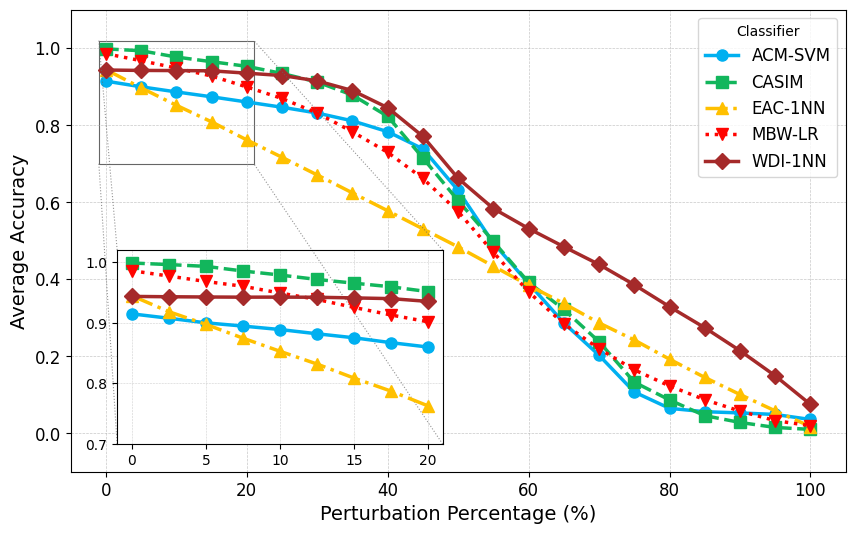

In [28]:
plot_robustness_results_subfigure(CLASSIFIERS, 
                                  SAVE_DIR_TEP + "/0_100_5/tep", 
                                  save_filename='tep_robustness_plot_subfigure.pdf',
                                  fine_results_folder="results/0_20_25/tep",
                                  inset_xlim=(0, 20),
                                  inset_width="42%",
                                  inset_height="42%",
                                  inset_bbox=(0.06, 0.06, 1, 1))

In [ ]:
plot_robustness_results(CLASSIFIERS_EAC_KNN, SAVE_DIR_TEP, save_filename='tep_robustness_plot_eac_knn.svg')

In [ ]:
plot_robustness_results_subfigure(CLASSIFIERS_EAC_KNN, 
                                  SAVE_DIR_TEP, 
                                  save_filename='tep_robustness_plot_eac_knn_subfigure.svg',
                                  fine_results_folder=None,
                                  inset_xlim=(0, 20),
                                  inset_width="42%",
                                  inset_height="42%",
                                  inset_bbox=(0.06, 0.06, 1, 1))

### Fluidized Catalytic Cracking (FCC)

In [90]:
X, y = load_dataset_from_folder("data/fcc", MAX_DATA_LENGTH)

Class mapping (label_index -> folder_name):
  0: V2_high
  1: V2_low
  2: V3_high
  3: V3_low
  4: V4_high
  5: V4_low
  6: V6_high
  7: V6_low
  8: V7_high
  9: V7_low
  10: V8_high
  11: V8_low
  12: catalyst_deactivation
  13: cyclone_damage
  14: preheater_shutdown
  15: preheater_temp_increase


Loading dataset: 100%|██████████| 1600/1600 [00:05<00:00, 302.45file/s]


Data shape: (1600, 57, 60)
Labels shape: (1600,)


In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_FCC)

In [ ]:
perturber = CAELabelPerturber(random_state=RANDOM_SEED, epochs=NUM_EPOCHS)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS_EAC_KNN,
    perturber=perturber,
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
_ = robustness_tester.test_all_classifiers(X, y, perturbation_steps=PERTURBATION_STEPS, results_folder=SAVE_DIR_FCC)

In [ ]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_FCC, save_filename='fcc_robustness_plot.svg')

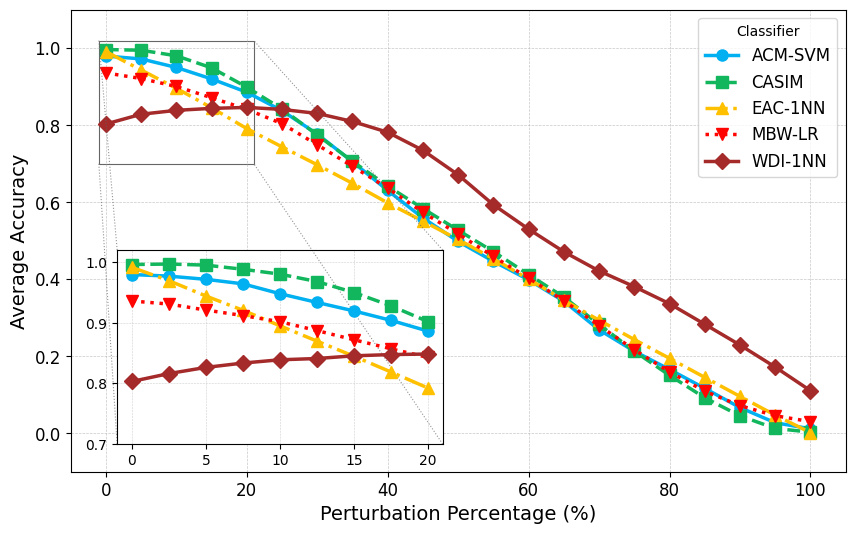

In [29]:
plot_robustness_results_subfigure(CLASSIFIERS, 
                                  SAVE_DIR_FCC + "/0_100_5/fcc", 
                                  save_filename='fcc_robustness_plot_subfigure.pdf',
                                  fine_results_folder="results/0_20_25/fcc",
                                  inset_xlim=(0, 20),
                                  inset_width="42%",
                                  inset_height="42%",
                                  inset_bbox=(0.06, 0.06, 1, 1))

In [ ]:
plot_robustness_results(CLASSIFIERS_EAC_KNN, SAVE_DIR_FCC, save_filename='fcc_robustness_plot_eac_knn.svg')

In [ ]:
plot_robustness_results_subfigure(CLASSIFIERS_EAC_KNN, 
                                  SAVE_DIR_FCC, 
                                  save_filename='fcc_robustness_plot_eac_knn_subfigure.svg',
                                  fine_results_folder=None,
                                  inset_xlim=(0, 20),
                                  inset_width="42%",
                                  inset_height="42%",
                                  inset_bbox=(0.06, 0.06, 1, 1))

## AE Architecture Visualization

In [72]:
import visualkeras

# Example: 50 sensors, 100 time steps
input_shape = X.shape[1:]  # Get (features, time) from X shape

perturber = CAELabelPerturber(latent_dim=32, epochs=10)
perturber._build_autoencoder(input_shape)
model = perturber.autoencoder

# Patch layers to have an 'output_shape' attribute for visualkeras

for layer in model.layers:
    if not hasattr(layer, "output_shape"):
        try:
            # Most tf.keras layers have .output as a Tensor with .shape
            shape = layer.output.shape
            # Convert TensorShape to a tuple/list of ints/None
            if hasattr(shape, "as_list"):
                shape = shape.as_list()
            layer.output_shape = tuple(shape)
        except Exception as e:
            # Fallback: try compute_output_shape if available
            if hasattr(layer, "compute_output_shape"):
                try:
                    out_shape = layer.compute_output_shape(model.input_shape)
                    if hasattr(out_shape, "as_list"):
                        out_shape = out_shape.as_list()
                    layer.output_shape = tuple(out_shape)
                except Exception as e2:
                    print(f"Could not patch layer '{layer.name}': {e2}")
            else:
                print(f"Could not patch layer '{layer.name}': {e}")


TEP Autoencoder Architecture with input shape: (None, 50, 60, 1)


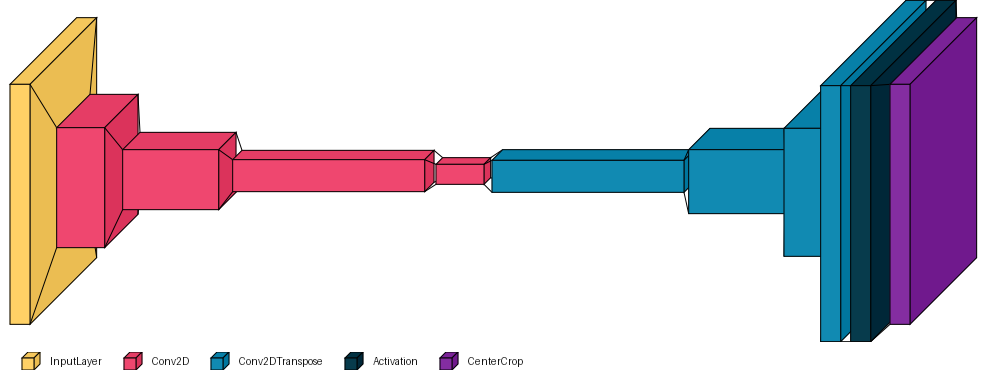

In [67]:
print("\nTEP Autoencoder Architecture with input shape:", model.input_shape)
visualkeras.layered_view(model, legend=True).show() # display using your system viewer
visualkeras.layered_view(model, legend=True, to_file='tep_ae_architecture.png') # write to disk


FCC Autoencoder Architecture with input shape: (None, 57, 60, 1)


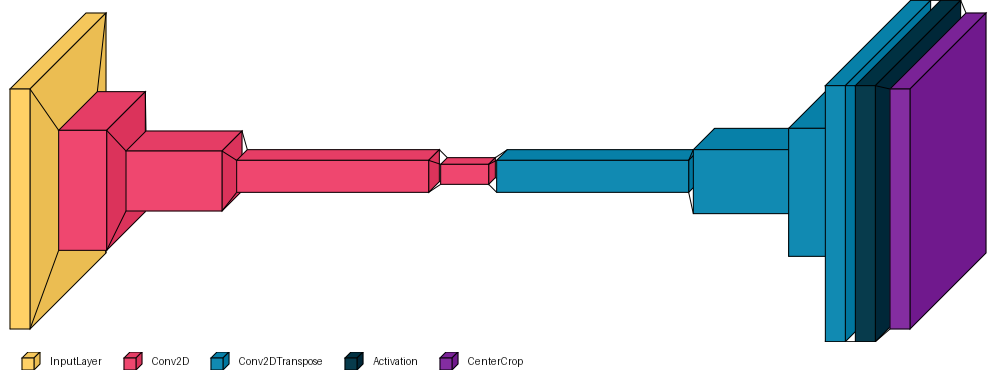

In [73]:
print("\nFCC Autoencoder Architecture with input shape:", model.input_shape)
visualkeras.layered_view(model, legend=True).show() # display using your system viewer
visualkeras.layered_view(model, legend=True, to_file='fcc_ae_architecture.png') # write to disk